Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях
h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

#### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .



#### 2. Оцените ошибки моделей из п.1 .



In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])
data.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DUQ_MW  119068 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [4]:
data.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


In [5]:
data['date'] = data.index
data

,DUQ_MW,date
Datetime,,
2005-12-31 01:00:00,1458.0,2005-12-31 01:00:00
2005-12-31 02:00:00,1377.0,2005-12-31 02:00:00
2005-12-31 03:00:00,1351.0,2005-12-31 03:00:00
2005-12-31 04:00:00,1336.0,2005-12-31 04:00:00
2005-12-31 05:00:00,1356.0,2005-12-31 05:00:00
...,...,...
2018-01-01 20:00:00,1962.0,2018-01-01 20:00:00
2018-01-01 21:00:00,1940.0,2018-01-01 21:00:00
2018-01-01 22:00:00,1891.0,2018-01-01 22:00:00


In [6]:
b_ar = data['DUQ_MW'].values
b_s = pd.DataFrame(data = data[['DUQ_MW']])
b_s.head()


,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


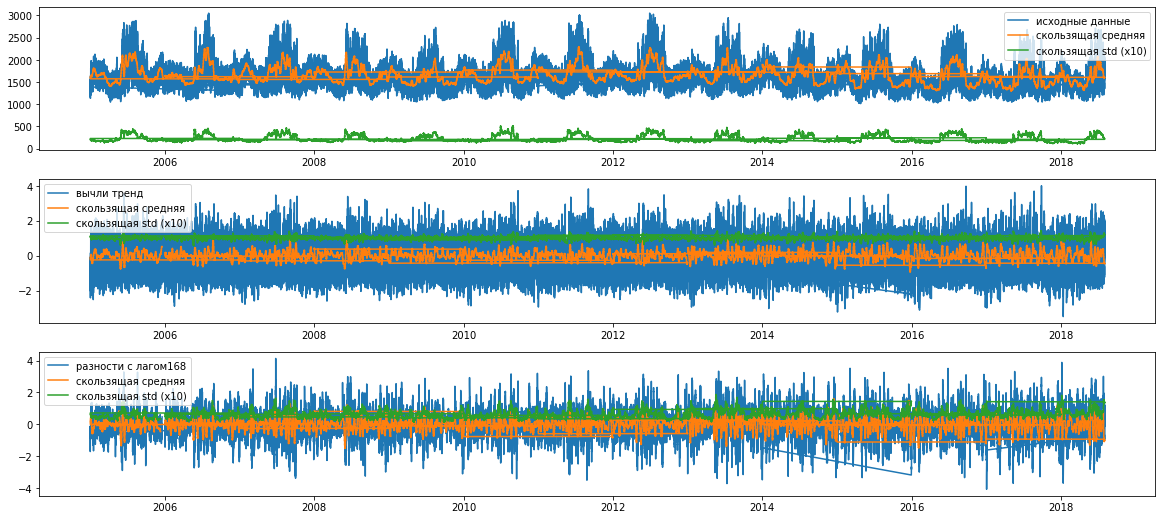

In [7]:
#import matplotlib.dates as mdates
train = b_s.iloc[:-10, :]
test = b_s.iloc[-10:, :]


N2 = 24*7

b_s['z_data'] = (b_s['DUQ_MW'] - b_s['DUQ_MW'].rolling(window=N2).mean()) / b_s['DUQ_MW'].rolling(window=N2).std()
b_s['zp_data'] = b_s['z_data'] - b_s['z_data'].shift(N2)

def plot_rolling(b_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(b_s.index, b_s['DUQ_MW'], label='исходные данные')
    ax[0].plot(b_s['DUQ_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s['DUQ_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом" +str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(b_s)    

Text(0.5, 1.0, 'DUQ MW')

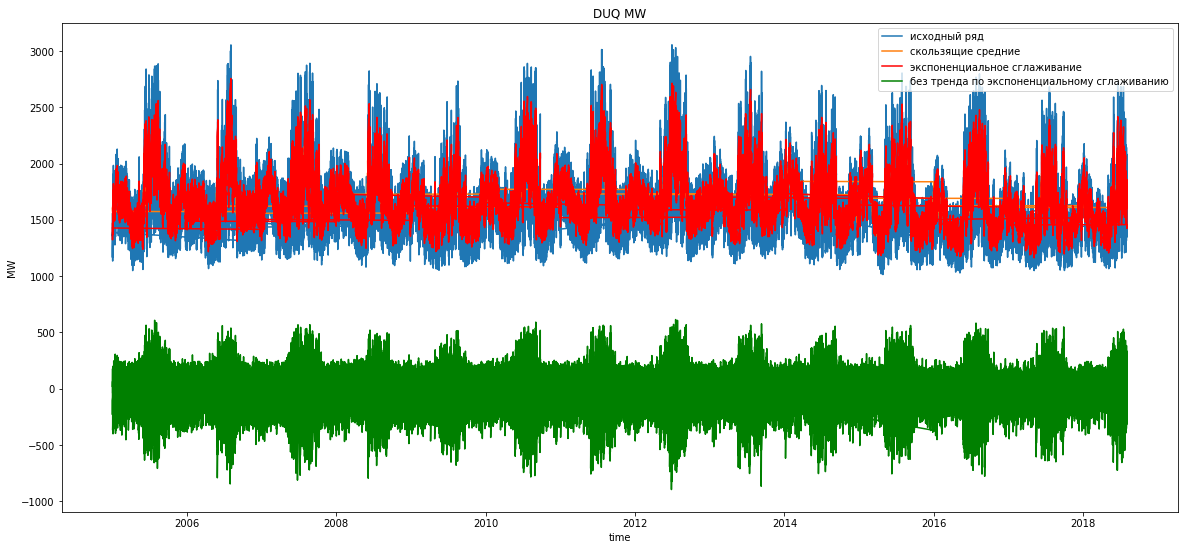

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

b_ar_exp_1 = exponential_smoothing(data['DUQ_MW'], 0.1)

plt.figure(figsize=(20, 9))
plt.plot(b_s.index, b_s['DUQ_MW'], label='исходный ряд')
plt.plot(b_s['DUQ_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(b_s.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(b_s.index,b_s['DUQ_MW'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('DUQ MW')

In [9]:
b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = b_s.index)
#без тренда 
data_trend_free = (b_s['DUQ_MW'] - b_ar_exp_1.iloc[:,0])
data_trend_free.head()
DF_ = sm.tsa.stattools.adfuller(data_trend_free , regression = 'ctt')
DF_

(-46.62724892831524,
 0.0,
 71,
 118996,
 {'1%': -4.371227385635095,
  '5%': -3.832439630281437,
  '10%': -3.553290754348759},
 1180413.5407414993)

In [10]:
d_data=data.resample('D').mean()


Text(0.5, 1.0, 'DUQ_MW')

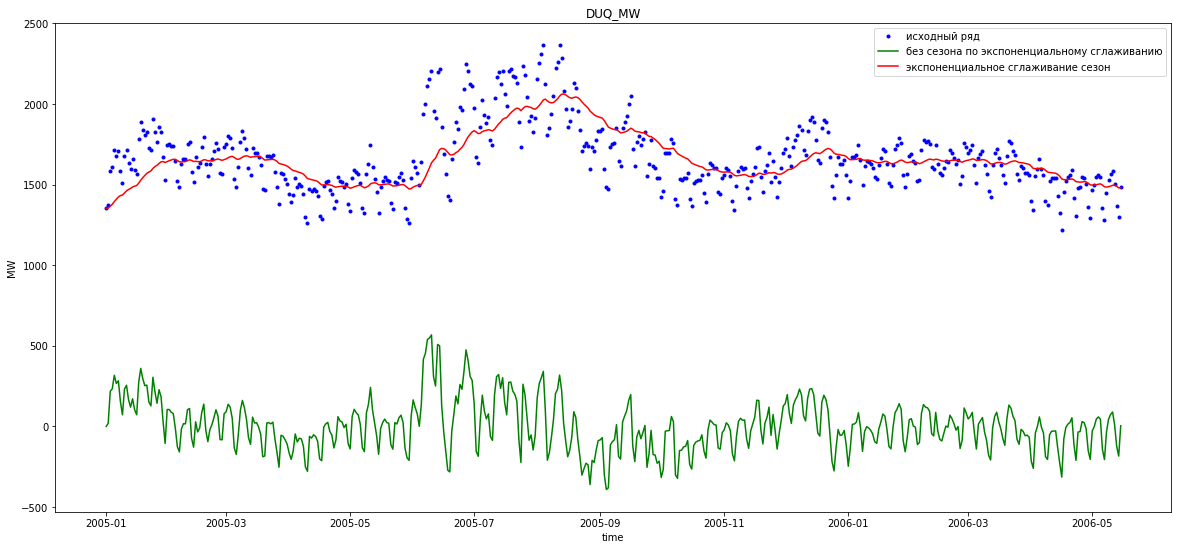

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


data_exp_1 = exponential_smoothing(d_data['DUQ_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['DUQ_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['DUQ_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('DUQ_MW')

In [12]:
data_season_free = pd.DataFrame(data = (np.array(d_data['DUQ_MW']).reshape((d_data['DUQ_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_season_free.iloc[:,0] , regression = 'ctt')
DF_

(-7.5603075211851305,
 3.8560655919639595e-09,
 29,
 4933,
 {'1%': -4.3734805929102025,
  '5%': -3.833587696490693,
  '10%': -3.5540020789762403},
 57985.25736145858)

In [13]:
df= pd.DataFrame(b_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values

df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Datetime,,,,,,,,
2005-12-31 01:00:00,1458.0000,0.000,0.00,0.0,1458.000000,1458.000000,1458.000000,0.0000
2005-12-31 02:00:00,1449.9000,1458.000,0.00,0.0,1457.919000,1457.757000,1457.352000,8.1000
2005-12-31 03:00:00,1440.0100,1449.900,1458.00,0.0,1457.739910,1457.224590,1455.964640,9.8900
2005-12-31 04:00:00,1429.6090,1440.010,1449.90,1458.0,1457.458601,1456.396122,1453.856189,10.4010
2005-12-31 05:00:00,1422.2481,1429.609,1440.01,1449.9,1457.106496,1455.371682,1451.327542,7.3609


In [14]:
df.columns

Index([0, 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08', 'diff1'], dtype='object')

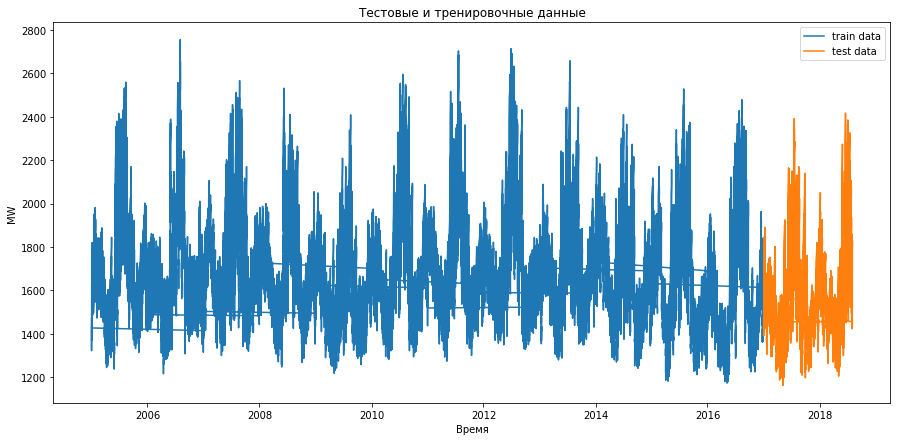

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[df.index.get_level_values('Datetime') <= split_date].copy(), \
           data.loc[df.index.get_level_values('Datetime') >  split_date].copy()

train_b, test_b = split_data_b(df, '2017-01-01')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(train_b.index.get_level_values('Datetime'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Datetime'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

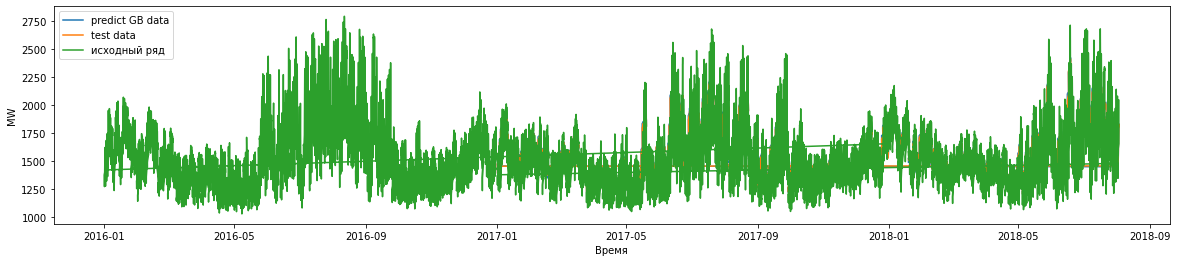

ошибка градиентного бустинга :   0.2094412514170173 %


In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(b_s.loc['2017-01-01':].index, b_s.loc['2017-01-01':]['DUQ_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

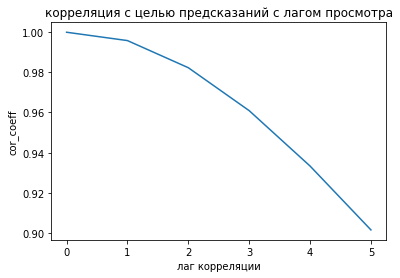

In [17]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

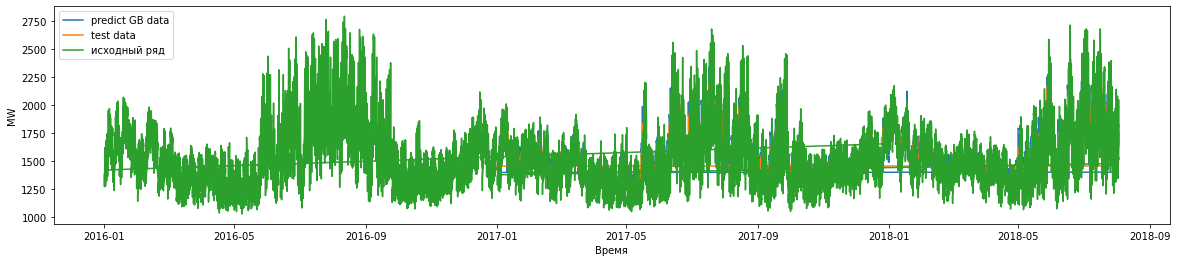

ошибка градиентного бустинга :   3.916772829034149 %


In [18]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2017-01-01':].index, b_s.loc['2017-01-01':]['DUQ_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

#### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.



Ошибка значительно возрастает с увеличением глубины прогноза - с 0,21% до 3.91%. 

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).
стационарность - на длительном промежутке ряд стационарный
тренд - время от времени наблюдаются тренды (потепление, похолодание), но они сильно не выбиваются за пределы стационарности
сезонность - ярко выражена
цикличность - ярко выражена (в пределах суток, времен года, лет)


б) Количество денег, которые тратят покупатели в интернет магазине.
стационарность - не стационарный, так как на длительном промежутке люди тратят все больше. 
тренд - восходящий
сезонность - ярко выражена, связана с праздниками, событиями
цикличность - годовая цикличность точно наблюдается. по месяцам и суткам - нужно анализировать данные, не обязательно должна наблюдаться

в) Вес растущего котенка.
стационарность - нет, но с определенного возраста становится стационарным
тренд - восходящий до определенного возраста
сезонность - нет
цикличность - нет

г) Прирост объема деревьев в лесу от времени
стационарность - да
тренд - зависит от засух, пожаров, количества осадков. При обычных условиях тренда нет, т.к. молодые деревья замещают старые. 
сезонность - в летний период увеличивается, в зимний - уменьшается. 
цикличность - аналогично сезонности